## Importing Libreries

In [18]:
import cv2
import pywt
import numpy as np
import imageio as iio
from matplotlib import pyplot as plt

### Loading the image

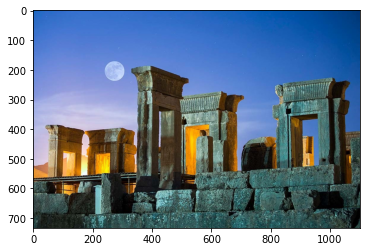

In [19]:
img = iio.imread("Q3.jpg").astype("float64")
plt.imshow(img.astype("uint8"));

### Making noisy image

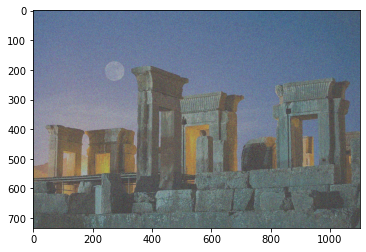

In [32]:
mu, sigma = 0, 45 # mean and standard deviation
noise = np.random.normal(mu, sigma, size=img.shape)
img_noisy = img.copy() + noise
def scale(img):
    return (img-np.min(img))/(np.max(img)-np.min(img))*255
plt.imshow(scale(img_noisy).astype("uint8"));

In [21]:
#wavelet with gaussian
def my_wavelet(img,sigma=1,k=21):
    L = cv2.GaussianBlur(img,ksize=(k,1),sigmaX=sigma,sigmaY=0)
    H = img-L
    
    LL = cv2.GaussianBlur(L,ksize=(1,k),sigmaX=0,sigmaY=sigma)
    LH = L - LL
    
    HL = cv2.GaussianBlur(H,ksize=(1,k),sigmaX=0,sigmaY=sigma)
    HH = H - HL
    return np.vstack(( np.hstack((LL,LH)),np.hstack((HL,HH)) ))

#plt.figure(figsize=(16,10));
#plt.figure(dpi=120)
#s = 2
#k = img_noisy.shape[0]//2+1
#plt.imshow(my_wavelet(img_noisy,k=k,sigma=s).astype("uint8"),);

In [22]:
temp = pywt.dwt2(img_noisy[:,:,0], 'haar')[0]
LL = np.zeros((temp.shape[0],temp.shape[1],3))
LH = LL.copy()
HL = LL.copy()
HH = LL.copy()
for i in range(3):
    coeffs2 = pywt.dwt2(img_noisy[:,:,i], 'haar')
    LLt, (LHt, HLt, HHt) = coeffs2
    LL[:,:,i] = LLt
    LH[:,:,i] = LHt
    HL[:,:,i] = HLt
    HH[:,:,i] = HHt
#LL = (LL-np.min(LL))/(np.max(LL)-np.min(LL))*255
#LH = (LH-np.min(LH))/(np.max(LH)-np.min(LH))*255
#HL = (HL-np.min(HL))/(np.max(HL)-np.min(HL))*255
#HH = (HH-np.min(HH))/(np.max(HH)-np.min(HH))*255

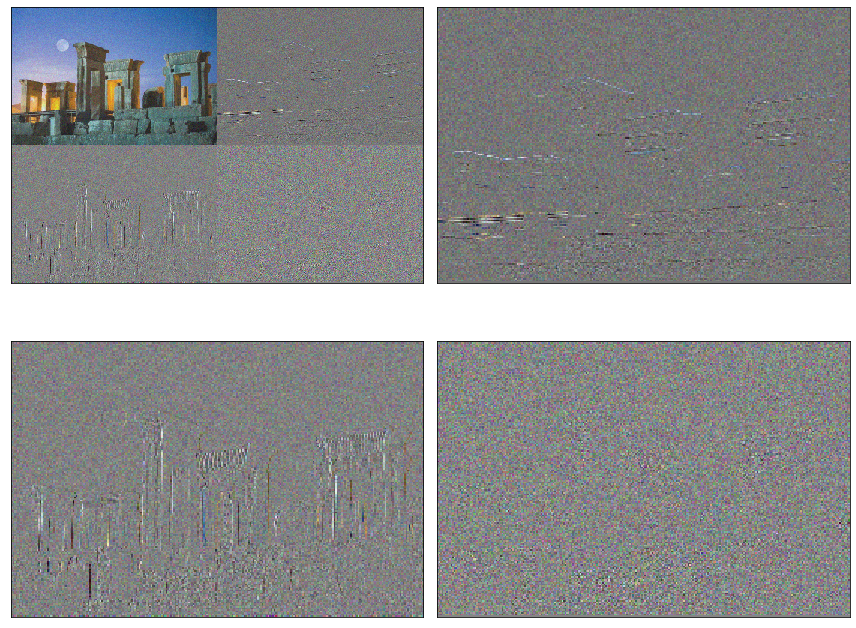

In [34]:
temp = pywt.dwt2(LL[:,:,0], 'haar')[0]
LLLL = np.zeros((temp.shape[0],temp.shape[1],3))
LLLH = LLLL.copy()
LLHL = LLLL.copy()
LLHH = LLLL.copy()
for i in range(3):
    coeffs2 = pywt.dwt2(LL[:,:,i], 'haar')
    LLt, (LHt, HLt, HHt) = coeffs2
    LLLL[:,:,i] = LLt
    LLLH[:,:,i] = LHt
    LLHL[:,:,i] = HLt
    LLHH[:,:,i] = HHt
#LLLL = (LLLL-np.min(LLLL))/(np.max(LLLL)-np.min(LLLL))*255
#LLLH = (LLLH-np.min(LLLH))/(np.max(LLLH)-np.min(LLLH))*255
#LLHL = (LLHL-np.min(LLHL))/(np.max(LLHL)-np.min(LLHL))*255
#LLHH = (LLHH-np.min(LLHH))/(np.max(LLHH)-np.min(LLHH))*255

fig = plt.figure(figsize=(12, 10))
allLLLL = np.vstack(( np.hstack((scale(LLLL),scale(LLLH))),np.hstack((scale(LLHL),scale(LLHH))) ))
for i, a in enumerate([allLLLL, LLLH, LLHL, LLHH]):
    ax = fig.add_subplot(2, 2, i + 1)
    ax.imshow(scale(a).astype("uint8"), interpolation="nearest", cmap="gray")
    ax.set_xticks([])
    ax.set_yticks([])
fig.tight_layout()
plt.show()

### Soft and Hard Shrinking functions

In [41]:
def soft(img,l):
    out = img.copy()
    
    out[img[:,:,0]>l] = img[img[:,:,0]>l] - l
    out[img[:,:,1]>l] = img[img[:,:,1]>l] - l
    out[img[:,:,2]>l] = img[img[:,:,2]>l] - l
    
    out[np.abs(img[:,:,0])<l] = 0
    out[np.abs(img[:,:,1])<l] = 0
    out[np.abs(img[:,:,2])<l] = 0
    
    out[img[:,:,0]<-l] = img[img[:,:,0]<-l] + l
    out[img[:,:,1]<-l] = img[img[:,:,1]<-l] + l
    out[img[:,:,2]<-l] = img[img[:,:,2]<-l] + l
    
    return out

def hard(img,l):
    out = img.copy()
    out[img[:,:,0]<l] = 0
    out[img[:,:,1]<l] = 0
    out[img[:,:,2]<l] = 0
    return out.astype("float64")

### VisoShrink

In [39]:
VLL = LL.copy()
l_viso = sigma*np.sqrt(2*np.log(LH.shape[0]*LH.shape[1]))
VLH = soft(LH,l_viso)
VHL = soft(HL,l_viso)
VHH = soft(HH,l_viso)

VLLLL = LLLL.copy()
l_viso = sigma*np.sqrt(2*np.log(LLLH.shape[0]*LLLH.shape[1]))
VLLLH = soft(LLLH,l_viso)
VLLHL = soft(LLHL,l_viso)
VLLHH = soft(LLHH,l_viso)

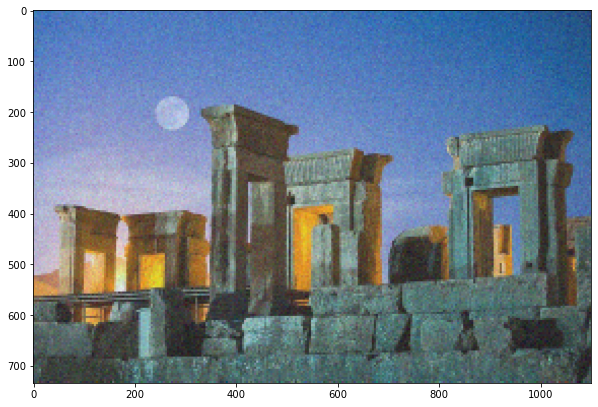

In [44]:
tVLL = np.zeros((2*VLLLL.shape[0],2*VLLLL.shape[1],3))
for i in range(3):
    coeffs = VLLLL[:,:,i],(VLLLH[:,:,i],VLLHL[:,:,i],VLLHH[:,:,i])
    tVLL[:,:,i] = pywt.idwt2(coeffs,'haar','smooth')

VLL = np.zeros(VHH.shape)
VLL = tVLL[1:368,:,:]
#VLL = (VLL-np.min(VLL))/(np.max(VLL)-np.min(VLL))*255

Viso = np.zeros((2*VLL.shape[0],2*VLL.shape[1],3))
for i in range(3):
    coeffs = VLL[:,:,i],(VLH[:,:,i],VHL[:,:,i],VHH[:,:,i])
    Viso[:,:,i] = pywt.idwt2(coeffs,'haar','smooth')

#Viso = (Viso-np.min(Viso))/(np.max(Viso)-np.min(Viso))*255
#Viso_eq = cv2.blur(Viso.copy(),ksize=(115,115))
Viso_eq = Viso.copy()
for i in range(Viso.shape[2]):
    Viso_eq[:,:,i] = cv2.equalizeHist(Viso[:,:,i].astype("uint8"))
plt.figure(figsize=(10,10))
plt.imshow(scale(Viso).astype("uint8"));